<a href="https://colab.research.google.com/github/toufiqmusah/Introduction-to-TorchIO/blob/main/Introduction_to_TorchIO_for_3D_MRI_Processing_Augmentation_Transforms_%26_DataLoaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# library installs & dataset download

# !pip -q install gdown
!pip -q install torchio

!gdown -q 1osj3lgzNlsW-esdq0KQvvLB7yiadyZGA
!unzip -q "/content/BraTS-SSA-Samples.zip" -d "/content/BraTS-SSA-Samples"

In [ ]:
# Importing Libraries...

import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

import torchio as tio

# Augmentations

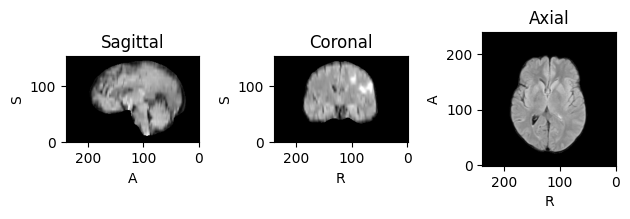

MRI Shape: (1, 240, 240, 155)


In [ ]:
# Loading and Viewing MRI Sample

mri_path = '/content/BraTS-SSA-Samples/BraTS-SSA-00049-000/BraTS-SSA-00049-000-t2f.nii'

mri_sample = tio.ScalarImage(mri_path)
mri_sample.plot()
print("MRI Shape:",mri_sample.shape)

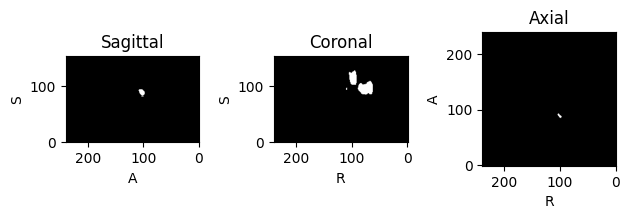

MRI Shape: (1, 240, 240, 155)


In [ ]:
# Loading and Viewing Corresponding Segmentation Maps

seg_path = '/content/BraTS-SSA-Samples/BraTS-SSA-00049-000/BraTS-SSA-00049-000-seg.nii'

seg_sample = tio.ScalarImage(seg_path)
seg_sample.plot()
print("MRI Shape:",seg_sample.shape)

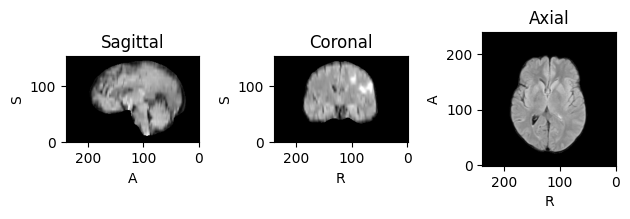

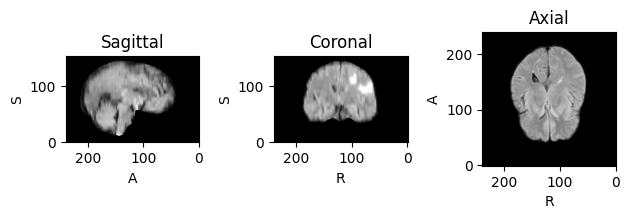

In [ ]:
# Applying Random Flip to MRI

random_flip = tio.RandomFlip(p=0.9, axes=(0,1,2))
mri_flipped = random_flip(mri_sample)

mri_sample.plot()
mri_flipped.plot()

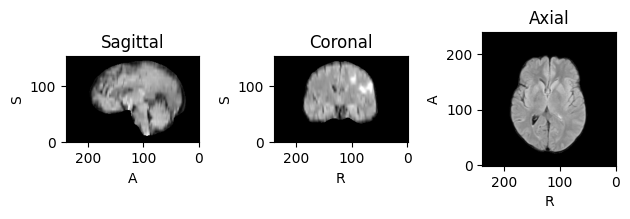

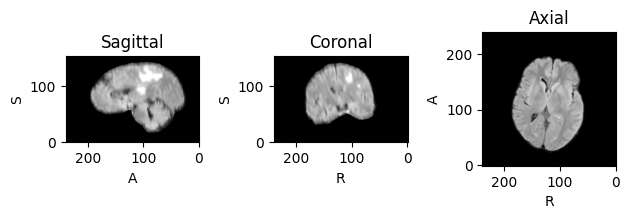

In [ ]:
# Applying Random Affine to MRI

random_affine = tio.RandomAffine(p=0.9)
mri_affine = random_affine(mri_sample)

mri_sample.plot()
mri_affine.plot()

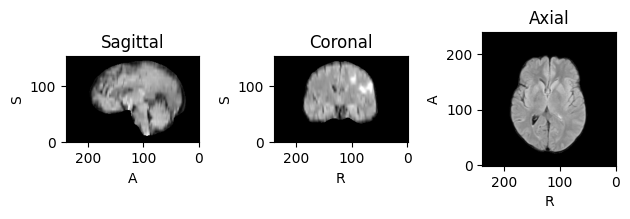

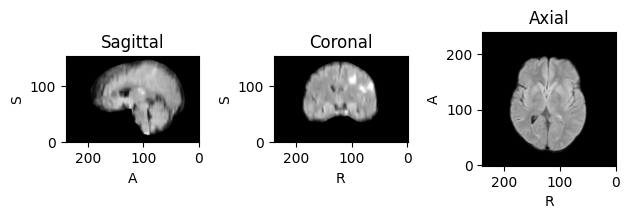

In [ ]:
# Applying Random Elastic Transformations to MRI

random_elastic = tio.RandomElasticDeformation(p=0.9)
mri_elastic = random_elastic(mri_sample)

mri_sample.plot()
mri_elastic.plot()

# Custom Dataset & DataLoader

In [ ]:
# imports and all ..

import os
from glob import glob

import torchio
from torchio.data import SubjectsLoader, SubjectsDataset

In [ ]:
# Custom Dataset - 🧠

class SegmentationDataset(SubjectsDataset):
    def __init__(self, root_dir: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Recursively Finding MRI and Segmentation Label Paths with Glob
        self.t2f_paths = sorted(glob(os.path.join(root_dir, "**", "*t2f*.nii"), recursive=True))
        self.t1c_paths = sorted(glob(os.path.join(root_dir, "**", "*t1c*.nii"), recursive=True))
        self.seg_paths = sorted(glob(os.path.join(root_dir, "**", "*seg*.nii"), recursive=True))

        self.subjects = [
            tio.Subject(
                mri=tio.ScalarImage([t1c_path, t2f_path]),
                label=tio.LabelMap(seg_path)
            )
            for t2f_path, t1c_path, seg_path in zip(self.t2f_paths, self.t1c_paths, self.seg_paths)]

        super().__init__(self.subjects, transform=transform)

In [ ]:
# Preprocessing Transforms:

preprocessing_transforms = tio.Compose(
    [
        tio.RescaleIntensity(out_min_max=(0, 99.5), include = ['mri']),
        tio.ZNormalization(include = ['mri']),
        tio.Resample((2.2, 2.2, 2.0), include = ['mri', 'label']),
        tio.CropOrPad((96, 96, 64), include = ['mri', 'label']),
        tio.OneHot(num_classes = 4, include = ['label']),
    ]
)

# Augmentation Transforms:

augmentation_transforms = tio.Compose(
    [
        tio.RandomFlip(axes=(0,1,2), p=0.5, include = ['mri', 'label']),
        tio.RandomAffine(p=0.5, include = ['mri', 'label']),
        tio.RandomElasticDeformation(p=0.5, include = ['mri', 'label']),
        # tio.RandomNoise(p = 0.3, include = ['mri']),
    ]
)

# All the Transforms

data_transforms = tio.Compose(
    [
        preprocessing_transforms,
        augmentation_transforms
    ]
)

In [ ]:
# data transforms, loading

dataset = SegmentationDataset('/content/BraTS-SSA-Samples/', transform=data_transforms)

dataloader = SubjectsLoader(dataset, batch_size=4, shuffle=True)

batch = next(iter(dataloader))
mri_data = batch['mri'][tio.DATA]
seg_data = batch['label'][tio.DATA]

print(mri_data.shape, seg_data.shape)

torch.Size([4, 2, 96, 96, 64]) torch.Size([4, 4, 96, 96, 64])


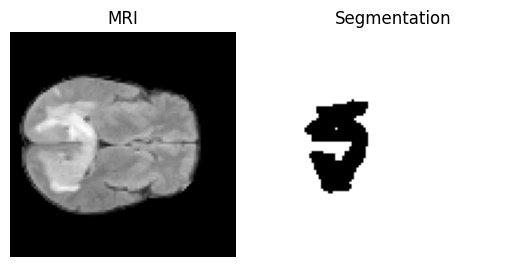

In [ ]:
plt.subplot(1,2,1)
plt.imshow(mri_data[0,1,...,32], cmap = 'gray')
plt.title('MRI')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(seg_data[0,0,...,32], cmap = 'gray')
plt.title('Segmentation')
plt.axis('off')
plt.show()